In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/home/dana_z/ssd_2TB/6OHDA')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as Mcolors
import matplotlib.cm as cmx
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings
import pandas as pd
import sqlalchemy as db
import gc
from tqdm import tqdm
import seaborn as sns
import pywt # wavelet package
import matplotlib.cm as cm

In [3]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5','FinalData_6OHDA_H_skip.h5','FinalData_6OHDA_skip.h5']
miceList = getMiceList(Files[0])

In [4]:
#path to folder where figures should be saved
figFolder = '/home/dana_z/ssd_2TB/6OHDA/figs/paper1_edit5/'

In [5]:
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Day 1-13'
    else:
        return 'Day 14-35'

<IPython.core.display.Javascript object>


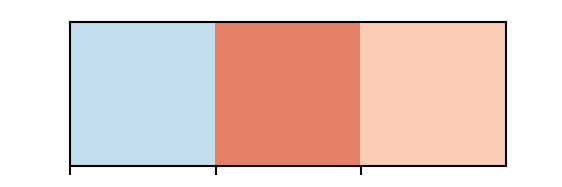

<IPython.core.display.Javascript object>


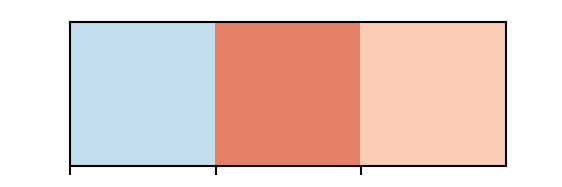

In [6]:
a3 = np.array(sns.color_palette("RdBu_r", n_colors=7))
# a3 = np.concatenate((a3[2,:],a3[4:,:]))
colorPallet3Post =(a3[[2,5,4],:])
sns.palplot(sns.color_palette(colorPallet3Post)) 

colorPallet3 =(a3[[2,5,4],:])
sns.palplot(sns.color_palette(colorPallet3))

In [11]:
# plot Get statistics for Gamma Power
df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/sessions')
savePath = '/home/dana_z/HD1/lfp2ca_notNormalize/'
Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
f.close()
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta_10to15':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
highGamma = fr['high_Gamma']
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = df[df.sess==sess].cre.values[0]
    try: 
        #tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'MSN/'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        mu = np.nanmean(A[:int(A.shape[0]/2),:,:],axis=0)
        Std = np.nanstd(A[:int(A.shape[0]/2),:,:],axis=0)
        A =(A-mu)/Std
        A = A[t200,:,:][:,highGamma,:]
        b = np.arange(A.shape[2])
        A = np.mean(np.mean(A,axis = 0),axis=0)
        df2 = pd.DataFrame(np.array([A,b]).T,columns = ['gamma','cellNum'])
        df2['Mouse']=m
        df2['Period'] = period
        df2['Sess'] = sess
        df2['CellType'] = 'MSN'
        
        Pdf = pd.concat([Pdf,df2])
        del A,b
        
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)
            

Pdf.to_csv(figFolder+'gammaSort.csv')

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [28]:
print(Pdf[Pdf.gamma>.75].groupby('Period').gamma.count()/Pdf.groupby('Period').gamma.count())
print(Pdf[Pdf.gamma>.75].groupby(['Mouse','Period']).gamma.count()/Pdf.groupby(['Mouse','Period']).gamma.count())

Period
Day 1-13     0.143332
Day 14-35    0.169014
Healthy      0.090513
Name: gamma, dtype: float64
Mouse  Period   
0761   Day 1-13     0.137255
       Day 14-35    0.181818
       Healthy      0.301887
1208   Day 1-13     0.065217
       Day 14-35    0.175287
       Healthy      0.104326
1222   Day 1-13     0.120000
       Day 14-35    0.201389
       Healthy      0.084942
1231   Healthy      0.038261
1236   Day 1-13     0.158590
       Day 14-35    0.152174
       Healthy      0.210526
1253   Healthy      0.025830
1793   Day 1-13     0.086614
       Day 14-35    0.046990
       Healthy      0.042538
2976   Day 1-13     0.112613
       Day 14-35    0.075117
       Healthy      0.041096
2980   Day 1-13     0.243056
       Day 14-35    0.317204
       Healthy      0.168254
2981   Day 1-13     0.063457
       Day 14-35    0.215369
       Healthy      0.097368
4539   Day 1-13     0.373166
       Day 14-35    0.745283
       Healthy      0.083995
7584   Day 1-13     0.157858
       Day 1

In [139]:
Pdf = pd.read_csv(figFolder+'gammaSort.csv')
Pdf['gammaPercent'] = Pdf.gamma.apply(lambda x: x>=0.75)
Pdf =Pdf.groupby(['Sess','Period']).mean()
Pdf =Pdf.groupby(['Mouse','Period']).mean()
Pdf = Pdf.reset_index()
Pdf['Mouse']=Pdf['Mouse'].astype(int)
Pdf.dtypes

Mouse             int64
Period           object
Unnamed: 0      float64
gamma           float64
cellNum         float64
gammaPercent    float64
dtype: object

In [140]:
df = pd.read_csv(figFolder+'speedData.csv')
df = df.groupby(['Mouse','Period']).mean()
df = df.reset_index()
df
print(df.dtypes)
df2 = pd.merge(Pdf,df[['Mouse','Period','MvmtOnset']],on=['Mouse','Period'])
df = pd.read_csv(figFolder+'rotation_forR.csv')
df = df.groupby(['Mouse','Period']).mean()
df = df.reset_index()
df2 = pd.merge(df2,df[['Mouse','Period','cRotOnset','rotOnset','percent_high_C','percent_high_AC']],on=['Mouse','Period'])
df2

Mouse               int64
Period             object
Unnamed: 0        float64
Day               float64
percent_low       float64
percent_high      float64
percent_medium    float64
tran_all          float64
tran_low2any      float64
tran_high2any     float64
MvmtOnset         float64
dtype: object


,Mouse,Period,Unnamed: 0,gamma,cellNum,gammaPercent,MvmtOnset,cRotOnset,rotOnset,percent_high_C,percent_high_AC
0,761,Day 1-13,3.916667,0.338312,3.916667,0.168799,9.428571,0.285714,9.285714,0.012582,0.140885
1,761,Day 14-35,3.750000,0.300094,3.750000,0.129464,2.500000,0.500000,4.250000,0.011682,0.049687
2,761,Healthy,8.500000,0.426919,8.500000,0.258909,12.333333,4.666667,13.000000,0.046699,0.157744
3,1208,Day 1-13,78.200000,0.064112,78.200000,0.062579,12.333333,1.500000,12.833333,0.012633,0.162891
4,1208,Day 14-35,69.200000,0.275943,69.200000,0.174771,11.200000,0.400000,12.800000,0.010320,0.184061
5,1208,Healthy,130.666667,0.128004,130.666667,0.100377,12.000000,1.333333,5.333333,0.013810,0.098828
6,1222,Day 1-13,3.916667,-0.041819,3.916667,0.077652,7.333333,1.833333,5.166667,0.248145,0.315625
7,1222,Day 14-35,14.100000,0.311547,14.100000,0.187378,7.800000,1.200000,6.400000,0.145121,0.339775
8,1222,Healthy,42.666667,0.188918,42.666667,0.072355,11.666667,4.333333,7.333333,0.205245,0.109246
9,1231,Healthy,95.500000,0.040500,95.500000,0.038982,11.333333,10.333333,11.000000,0.397370,0.083339


In [50]:
%matplotlib inline

0.03213147621639956


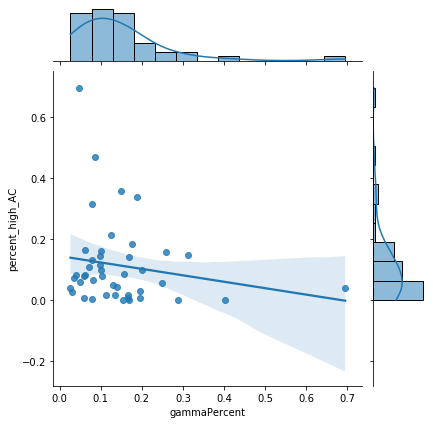

In [160]:
# sns.scatterplot(x='gammaPercent',y='percent_high_AC',hue = 'Period',data = df2)
def r2(x, y):
    return sci.stats.pearsonr(x, y)[0] ** 2
sns.jointplot(x='gammaPercent',y='percent_high_AC',data = df2, kind="reg")
print(r2(df2.gammaPercent,df2.percent_high_AC))

0.0005483021713982424


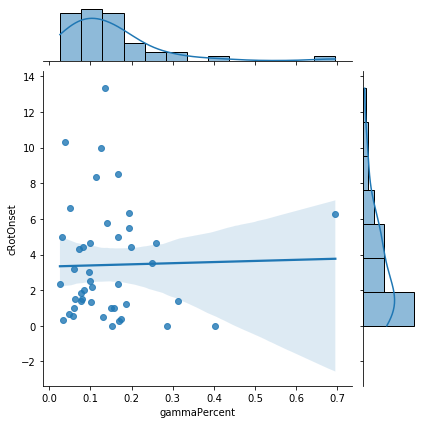

In [161]:
# sns.scatterplot(x='gammaPercent',y='cRotOnset',hue = 'Period',data = df2)
sns.jointplot(x='gammaPercent',y='cRotOnset',data = df2, kind="reg")
print(r2(df2.gammaPercent,df2.cRotOnset))

0.07290474357383947


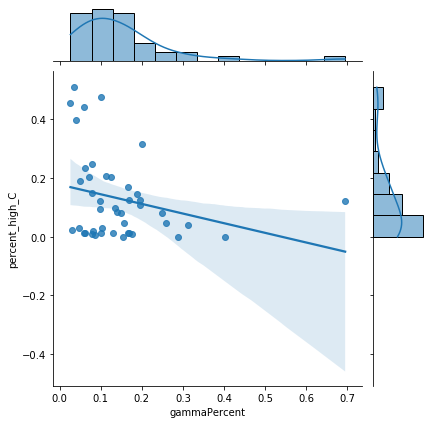

In [162]:
# sns.scatterplot(x='gammaPercent',y='percent_high_C',hue = 'Period',data = df2)
sns.jointplot(x='gammaPercent',y='percent_high_C',data = df2, kind="reg")
print(r2(df2.gammaPercent,df2.percent_high_C))

0.02368362482796734


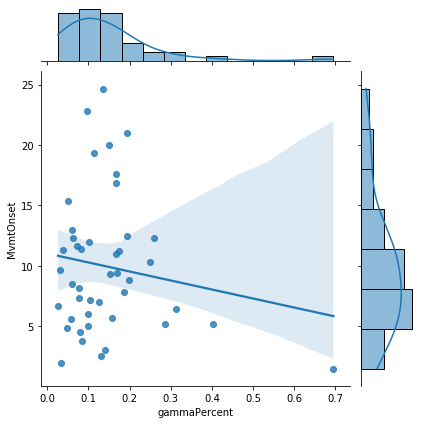

In [163]:
# sns.scatterplot(x='gammaPercent',y='MvmtOnset',hue = 'Period',data = df2)
sns.jointplot(x='gammaPercent',y='MvmtOnset',data = df2, kind="reg")
print(r2(df2.gammaPercent,df2.MvmtOnset))

In [84]:
Pdf = pd.read_csv(figFolder+'gammaSort.csv')
Pdf['gammaPercent'] = Pdf.gamma.apply(lambda x: x>=0.75)
Pdf =Pdf.groupby(['Sess','Period']).mean()
Pdf = Pdf.reset_index()
# Pdf['Mouse']=Pdf['Mouse'].astype(int)
# Pdf.dtypes

In [85]:
df = pd.read_csv(figFolder+'speedData.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
# print(df)
# print(df.dtypes)
df2 = pd.merge(Pdf,df[['Sess','Period','MvmtOnset']],on=['Sess','Period'])
df = pd.read_csv(figFolder+'rotation_forR.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
df2 = pd.merge(df2,df[['Sess','Period','cRotOnset','rotOnset','percent_high_C','percent_high_AC']],on=['Sess','Period'])
df2

,Sess,Period,Unnamed: 0,Mouse,gamma,cellNum,gammaPercent,MvmtOnset,cRotOnset,rotOnset,percent_high_C,percent_high_AC
0,0761_BaselineA,Healthy,5.0,761.0,0.427110,5.0,0.181818,14,3,13,0.042104,0.115976
1,0761_BaselineL,Healthy,7.5,761.0,0.362527,7.5,0.187500,15,3,17,0.030759,0.178418
2,0761_BaselineS,Healthy,13.0,761.0,0.491119,13.0,0.407407,8,8,9,0.067233,0.178839
3,0761_day10,Day 1-13,5.5,761.0,0.360169,5.5,0.166667,8,0,4,0.006555,0.142533
4,0761_day12,Day 1-13,2.0,761.0,0.121943,2.0,0.200000,6,0,3,0.012437,0.074118
...,...,...,...,...,...,...,...,...,...,...,...,...
204,8815_day2,Day 1-13,4.5,8815.0,0.029757,4.5,0.000000,16,1,11,0.042605,0.043277
205,8815_day30A,Day 14-35,39.0,8815.0,0.169259,39.0,0.151899,7,0,4,0.002017,0.045630
206,8815_day34L,Day 14-35,33.5,8815.0,0.085633,33.5,0.044118,16,11,15,0.043361,0.044538
207,8815_day4,Day 1-13,18.0,8815.0,0.249947,18.0,0.189189,4,1,4,0.026303,0.106050


In [50]:
%matplotlib inline

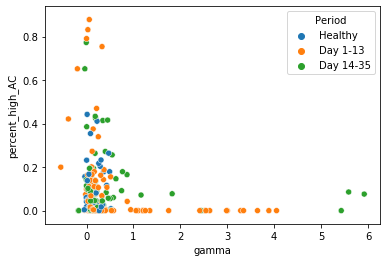

In [72]:
sns.scatterplot(x='gamma',y='percent_high_AC',hue = 'Period',data = df2)

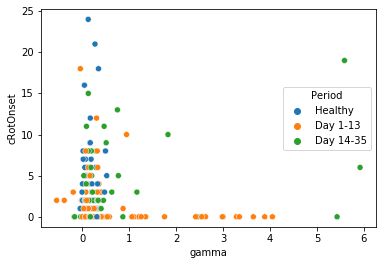

In [73]:
sns.scatterplot(x='gamma',y='cRotOnset',hue = 'Period',data = df2)

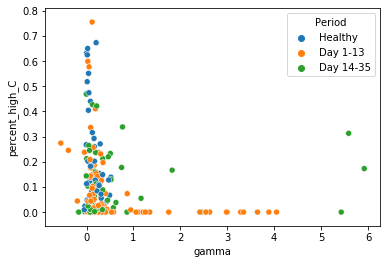

In [74]:
sns.scatterplot(x='gamma',y='percent_high_C',hue = 'Period',data = df2)

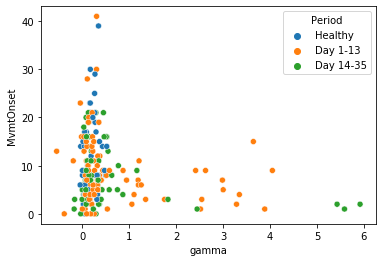

In [75]:
sns.scatterplot(x='gamma',y='MvmtOnset',hue = 'Period',data = df2)

In [97]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Post', mice=m, drug = b'L-Dopa')
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Post','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Post','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Post','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Post','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Post','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Post']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            Hs2 = Hs2.T
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByCol_meanPost = pd.DataFrame(specs)
df_normlizeByCol_meanPost = df_normlizeByCol_meanPost.T
# df.to_csv('specs_normlizeByRow_sum.csv')

  0%|          | 0/16 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  6%|▋         | 1/16 [01:13<18:20, 73.40s/it]

cleaning up lfp data
cleaning up speed data
found  3.0  outlier points
found  2.0  outlier points


 12%|█▎        | 2/16 [03:35<21:57, 94.12s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [05:50<23:02, 106.34s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [06:43<18:03, 90.31s/it] 

cleaning up lfp data
cleaning up speed data
found  447664.0  outlier points


 31%|███▏      | 5/16 [08:58<18:59, 103.56s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [09:45<14:27, 86.76s/it] 

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [11:34<14:01, 93.50s/it]

cleaning up lfp data
cleaning up speed data


 50%|█████     | 8/16 [14:20<15:22, 115.25s/it]

cleaning up lfp data
cleaning up speed data


 56%|█████▋    | 9/16 [16:06<13:06, 112.39s/it]

cleaning up lfp data
cleaning up speed data


 62%|██████▎   | 10/16 [18:13<11:41, 116.85s/it]

cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [20:05<03:00, 90.14s/it] 

cleaning up lfp data
cleaning up speed data


 94%|█████████▍| 15/16 [21:54<01:35, 95.87s/it]

cleaning up lfp data
cleaning up speed data


100%|██████████| 16/16 [23:51<00:00, 89.49s/it] 


In [173]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m, drug = b'L-Dopa')
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            Hs2 = Hs2.T
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByCol_meanPre = pd.DataFrame(specs)
df_normlizeByCol_meanPre = df_normlizeByCol_meanPre.T
# df.to_csv('specs_normlizeByRow_sum.csv')

  0%|          | 0/16 [00:00<?, ?it/s]/home/dana_z/ssd_2TB/6OHDA/IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value


cleaning up lfp data
cleaning up speed data


/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  6%|▋         | 1/16 [00:26<06:30, 26.01s/it]

cleaning up lfp data
cleaning up speed data
found  17.0  outlier points


 12%|█▎        | 2/16 [00:58<06:30, 27.88s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [01:34<06:35, 30.40s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [01:45<04:55, 24.66s/it]

cleaning up lfp data
cleaning up speed data
found  481139.0  outlier points


 31%|███▏      | 5/16 [02:20<05:04, 27.68s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [02:32<03:50, 23.02s/it]

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [03:07<04:00, 26.70s/it]

cleaning up lfp data
cleaning up speed data


 50%|█████     | 8/16 [03:43<03:54, 29.30s/it]

cleaning up lfp data
cleaning up speed data


 56%|█████▋    | 9/16 [04:15<03:31, 30.17s/it]

cleaning up lfp data
cleaning up speed data


 62%|██████▎   | 10/16 [04:51<03:11, 31.90s/it]

cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [05:23<00:49, 24.72s/it]

cleaning up lfp data
cleaning up speed data


 94%|█████████▍| 15/16 [05:56<00:27, 27.31s/it]

cleaning up lfp data
cleaning up speed data


100%|██████████| 16/16 [06:29<00:00, 24.35s/it]


In [174]:
# df = df_normlizeByCol_meanPost
df = df_normlizeByCol_meanPre
# df.groupby(['mouse','period'])
periods = {'Healthy':{'axis':0},'Day 1-13':{'axis':1},'Day 14-35':{'axis':2}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periods.keys():
    for c in conds:
        periods[p][c] = np.zeros((87,1))
    for m in df[df.period == p].mouse.unique():
        for c in conds:
            try:
                te = np.array(df[(df.period == p)&(df.mouse == m)][c].tolist())
#                 print(te.shape)
                periods[p][c] = np.concatenate((periods[p][c],np.nanmean(te,axis=0).T),axis=1)                         
            except:
                print(m,c,p,te.shape)
                continue
for p in periods.keys():
    for c in conds:
        periods[p][c] = periods[p][c][:,1:]



8803 highAC Healthy (1,)
0761 highC Day 14-35 (2,)
0761 hiSpeed Day 14-35 (2,)
1208 highC Day 14-35 (2,)
1236 highAC Day 14-35 (2,)
2980 highC Day 14-35 (2,)
8803 highC Day 14-35 (2,)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [175]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'Sess'})
df

,Sess,mouse,day,period,all,highAC,highC,lowRot,lowSpeed,hiSpeed
0,0761_BaselineL,0761,0,Healthy,"[[0.028317944575055945, 0.042404741343348366, ...","[[0.017175769082858994, 0.03008794858631673, 0...","[[0.02024810813837574, 0.03613063664659965, 0....","[[0.03251517431718947, 0.04660735134274601, 0....","[[0.032633792249092235, 0.047944465932890985, ...","[[0.015899546334882594, 0.02312272458289229, 0..."
1,0761_day19L,0761,19,Day 14-35,"[[0.03168336526919768, 0.043191998149998564, 0...","[[0.018615684412122743, 0.031672292416287266, ...","[[0.022520274525074012, 0.030759750428970174, ...","[[0.03504054888359392, 0.047038679633853234, 0...","[[0.03436567342981783, 0.0463863993550688, 0.0...","[[0.023897436238956894, 0.01829713097708965, 0..."
2,0761_day35L,0761,35,Day 14-35,"[[0.030672500552085365, 0.04261165482594794, 0...","[[0.014969521893481153, 0.022805985838676608, ...",NaN,"[[0.03174397483310769, 0.04327470232558236, 0....","[[0.030967103575012846, 0.04296423938717012, 0...",NaN
3,1208_BaselineL,1208,0,Healthy,"[[0.028891570716313483, 0.029738692185699016, ...","[[0.026119273579516645, 0.02996491645815188, 0...","[[0.035681408172367916, 0.0330526333093353, 0....","[[0.03030361532100123, 0.029202278727545803, 0...","[[0.0299898601184436, 0.029882259081652842, 0....","[[0.02581566846475012, 0.029496272344901764, 0..."
4,1208_day19L,1208,19,Day 14-35,"[[0.02559035844243499, 0.029335286172665693, 0...","[[0.03134357536609687, 0.03279112049993568, 0....","[[0.040436716484509264, 0.03514854445296494, 0...","[[0.023666909270325585, 0.027466197103912703, ...","[[0.02338928634088294, 0.02722458996842011, 0....","[[0.0301423815961503, 0.03342569633243072, 0.0..."
5,1208_day34L,1208,34,Day 14-35,"[[0.02401843820065357, 0.026840486909024616, 0...","[[0.023753112308303476, 0.02586554375456847, 0...",NaN,"[[0.02466685589390886, 0.027513537759057967, 0...","[[0.024529097765738625, 0.028034815939510016, ...","[[0.025290130558325585, 0.02473846102773742, 0..."
6,1222_BaselineL,1222,0,Healthy,"[[0.028710788261100618, 0.04914563364202728, 0...","[[0.02500131619974802, 0.04763153927386518, 0....","[[0.025395061523753173, 0.05583637534956736, 0...","[[0.034176784191702225, 0.040027237407232734, ...","[[0.03651436329455914, 0.042224101008489424, 0...","[[0.024177987671180335, 0.05222653321980292, 0..."
7,1222_day20L,1222,20,Day 14-35,"[[0.015436689282462323, 0.026441897967264965, ...","[[0.015247388881135974, 0.025254096030854944, ...","[[0.013876218267575902, 0.026410295544529307, ...","[[0.018317712877966862, 0.025428720685965345, ...","[[0.021471374973128225, 0.026009840513947086, ...","[[0.014839036045380585, 0.025810526601047008, ..."
8,1222_day36L,1222,36,Day 14-35,"[[0.027879057071516715, 0.03885397705699966, 0...","[[0.018149724107778615, 0.029567468503326397, ...","[[0.017388678326528358, 0.04308723833947436, 0...","[[0.03187424870078077, 0.04000109801014761, 0....","[[0.03317565173370115, 0.04065805383785159, 0....","[[0.015698248153394927, 0.03362069971105614, 0..."
9,1231_BaselineL,1231,0,Healthy,"[[0.02484747084315177, 0.037753576857825655, 0...","[[0.024059683930982914, 0.03629834054012941, 0...","[[0.024328335823318458, 0.037673199887399776, ...","[[0.025925200951123106, 0.03901021529384284, 0...","[[0.02492080785993693, 0.040137587200762215, 0...","[[0.02378525342967954, 0.035176424657519835, 0..."


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


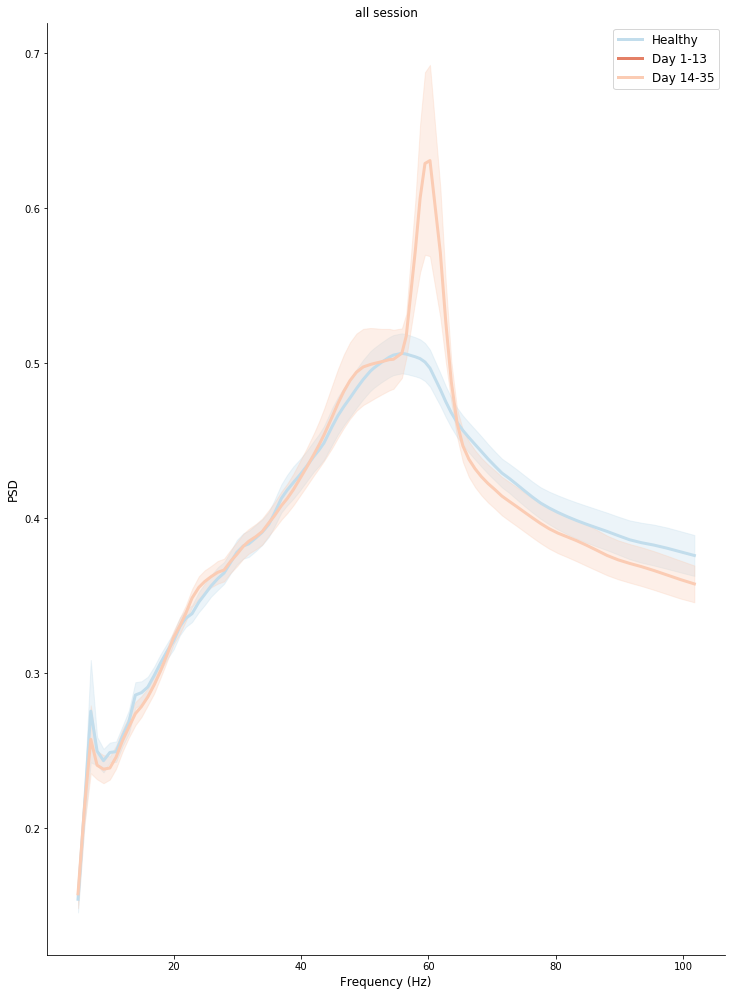

In [176]:
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,1,figsize=(12.15,17.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['lowSpeed'],axis=1)*freq
    hS2 = np.nanstd(periods[p]['lowSpeed'],axis=1)*freq/np.sqrt(periods[p]['all'].shape[1])
       
    ax.plot(freq,hC,color = colorsH[ind], label=p,linewidth=3.0)
    ax.fill_between(freq, hC-hS2, hC+hS2,color=colorsH[ind],alpha=0.3)
#     ax.set_xlim(6,100)
    ax.set_title('all session')
#     ax.set_xlim(60,100)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax.set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax.set_xlabel('Frequency (Hz)',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(fontsize=12)
fig.savefig(figFolder+'lfpSpectromPost_LDOPA_lowSpeed_freq.png',transparent=True,format='png')
# ax.set_xlim(10,30)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess_zoomBeta.svg',transparent=True,format='svg')



In [112]:
df

,index,mouse,day,period,all,highAC,highC,lowRot,lowSpeed,hiSpeed
0,0761_BaselineL,0761,0,Healthy,"[[0.029895043549235237, 0.04380962397832809, 0...","[[0.013082514115555834, 0.026648016329413802, ...","[[0.02043717368449259, 0.04314596214533848, 0....","[[0.03305334394635692, 0.04594715314293283, 0....","[[0.0324276091737728, 0.046590861968338664, 0....","[[0.012484387886450895, 0.019835570924664106, ..."
1,0761_day19L,0761,19,Day 14-35,"[[0.029731099730866507, 0.04419501652700044, 0...","[[0.013946082068581476, 0.02166028056677778, 0...","[[0.017171475520890628, 0.030248737688184327, ...","[[0.03315687082365611, 0.04792633433148214, 0....","[[0.0327076464410409, 0.04793818252238706, 0.0...","[[0.014351794488429279, 0.022639636728964626, ..."
2,0761_day35L,0761,35,Day 14-35,"[[0.02646740678833966, 0.04029770115475512, 0....","[[0.013075135992072039, 0.01656664623371631, 0...","[[0.023929141938690533, 0.02672665529414784, 0...","[[0.028082340170070316, 0.04240015555499986, 0...","[[0.028206610071908885, 0.042665327613450744, ...","[[0.014267630405991346, 0.020944467540079607, ..."
3,1208_BaselineL,1208,0,Healthy,"[[0.028057806140800372, 0.03081920632653361, 0...","[[0.026018569216110732, 0.03093388437261442, 0...","[[0.02983998940524834, 0.02660803775025098, 0....","[[0.02909103772481266, 0.030574846956605707, 0...","[[0.02904256930876143, 0.031145712105099924, 0...","[[0.02582831056875528, 0.029948612749163443, 0..."
4,1208_day19L,1208,19,Day 14-35,"[[0.029528442458084666, 0.030302475275540704, ...","[[0.036353482345353565, 0.03661707230593379, 0...","[[0.03576347941363574, 0.029164165189454132, 0...","[[0.026578911406813975, 0.027545701099168842, ...","[[0.026865986032583198, 0.02751212458134215, 0...","[[0.036466419650378855, 0.03704038033287169, 0..."
5,1208_day34L,1208,34,Day 14-35,"[[0.02509296091847466, 0.02845903158006613, 0....","[[0.026690186875265337, 0.02657797562852938, 0...","[[0.07893088084975382, 0.04492436555316403, 0....","[[0.02453106560200215, 0.029594400244818832, 0...","[[0.024602068050452827, 0.0296616541113774, 0....","[[0.02842013053770467, 0.029733114138488358, 0..."
6,1222_BaselineL,1222,0,Healthy,"[[0.03384615455738076, 0.0407946444719836, 0.0...","[[0.020094766884462774, 0.03961854554862171, 0...","[[0.018926019143610723, 0.04046213685926764, 0...","[[0.03758884162827089, 0.039816390585488, 0.03...","[[0.03835585080940317, 0.04035215803964906, 0....","[[0.01608481710892047, 0.036595749936370395, 0..."
7,1222_day20L,1222,20,Day 14-35,"[[0.023396546356860597, 0.04002836501365547, 0...","[[0.019076662472388456, 0.042186276207381315, ...","[[0.01674535012768679, 0.03939981425073275, 0....","[[0.02776033511141515, 0.04012071753388655, 0....","[[0.03214888714280794, 0.04138090987503155, 0....","[[0.01632402782734731, 0.03772683177998417, 0...."
8,1222_day36L,1222,36,Day 14-35,"[[0.027354810754451692, 0.04061777519899916, 0...","[[0.021282234747477417, 0.038855680385018285, ...","[[0.014370150466640743, 0.03817644919160315, 0...","[[0.030514959841956776, 0.04095945979414009, 0...","[[0.032442454372345324, 0.04132891206727962, 0...","[[0.017461902018137635, 0.034761956413723635, ..."
9,1231_BaselineL,1231,0,Healthy,"[[0.028375758967224468, 0.049201729978986176, ...","[[0.025374972089289686, 0.038436309794641854, ...","[[0.028766522545221402, 0.050226696240304104, ...","[[0.027677258459894258, 0.045470808385928506, ...","[[0.029350194940973472, 0.04870021906477773, 0...","[[0.02911086178294793, 0.04933991496613512, 0...."


In [177]:
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

beta = (freq>10)&(freq<16)
beta2 = (freq>15)&(freq<25)
gamma =(freq>40)&(freq<60)
highGamma = (freq>60)&(freq<100)
highGamma2 = (freq>80)&(freq<100)

# print(periods[p]['hiSpeed'].shape,np.nanmean(periods[p]['hiSpeed'][beta],axis=0).shape)
df2 = pd.DataFrame(columns = ['Period','Mouse','sess','mvmt','beta','gamma'])
# # fig, ax = plt.subplots(2,3,figsize=(12.15,17.15),sharey='row')
for row in range(len(df)):
    for mv in ['highAC', 'highC', 'lowRot', 'lowSpeed', 'hiSpeed','all']:
        try:
            te = np.array(df.iloc[row][mv])
            df3 = pd.DataFrame({'Period':df.iloc[row]['period'],'Mouse':df.iloc[row]['mouse'],'mvmt':mv,'sess':df.iloc[row]['Sess'],
                                'beta':np.nanmean(te[0,beta],axis=0),
                                'beta2':np.nanmean(te[0,beta2],axis=0),
                               'gamma':np.nanmean(te[0,gamma],axis=0),
                               'highGamma':np.nanmean(te[0,highGamma],axis=0),
                                'highGamma2':np.nanmean(te[0,highGamma2],axis=0),
                               'betaSum':np.nansum(te[0,beta],axis=0),
                                'betaSum2':np.nansum(te[0,beta2],axis=0),
                               'highGammaSum':np.nansum(te[0,highGamma],axis=0),
                                'highGammaSum2':np.nansum(te[0,highGamma2],axis=0),
                               'gammaSum':np.nansum(te[0,gamma],axis=0)},index=[0])
            df2 = pd.concat([df3,df2])
        except: 
            print(df.iloc[row]['Sess'],mv)

df2['ratio'] = df2.apply(lambda x: x.beta/x.gamma, axis = 1)
df2['ratio_High'] = df2.apply(lambda x: x.beta/x.highGamma, axis = 1)
# df['diff'] = 
df2.to_csv(figFolder+'lfpForR_Pre.csv')
df2.head()

0761_day35L highC
0761_day35L hiSpeed
1208_day34L highC
1236_day19L highAC
2980_day19L highC
8803_BaselineL highAC
8803_day34L highC


,Period,Mouse,mvmt,sess,beta,beta2,gamma,highGamma,highGamma2,betaSum,betaSum2,highGammaSum,highGammaSum2,gammaSum,ratio,ratio_High
0,Day 14-35,8815,all,8815_day34L,0.021555,0.016234,0.008810,0.005359,0.004222,0.129329,0.162341,0.160766,0.050668,0.176209,2.446501,4.022259
0,Day 14-35,8815,hiSpeed,8815_day34L,0.021065,0.015892,0.008606,0.005353,0.004219,0.126388,0.158925,0.160579,0.050629,0.172126,2.447597,3.935401
0,Day 14-35,8815,lowSpeed,8815_day34L,0.022163,0.016635,0.009000,0.005358,0.004217,0.132975,0.166355,0.160737,0.050606,0.180001,2.462494,4.136412
0,Day 14-35,8815,lowRot,8815_day34L,0.021733,0.016511,0.008919,0.005381,0.004220,0.130396,0.165112,0.161439,0.050642,0.178371,2.436793,4.038572
0,Day 14-35,8815,highC,8815_day34L,0.020750,0.015842,0.008984,0.005323,0.004234,0.124498,0.158425,0.159682,0.050810,0.179690,2.309498,3.898314


In [210]:
# df =pd.read_csv(figFolder+'lfpForR_Post.csv')
# df3 = df2.merge(df,on=['sess','mvmt','Period'])
# df3.to_csv(figFolder+'lfpForR_Ldopa.csv')
df4 = df3[['Period','Mouse_x','mvmt','sess','betaSum2_x','betaSum2_y']]
df4 = df4[df4.mvmt.isin(['hiSpeed','lowSpeed'])]

def difAplly(row,fr):
    try: 
        if row.mvmt in ['hiSpeed','lowSpeed']:
            low = float(df4[(df4.sess == row.sess)&(df4.Period == row.Period)&(df4.mvmt == 'hiSpeed')][fr].item())
        val = float(row[fr])
    except:
        return None
    if low==0:
        return None
    else: #base <0 and val >0:
        return (val-low)

df4['diff_pre'] = df4.apply(lambda row: difAplly(row,'betaSum2_x'),axis=1)    
df4['diff_post'] = df4.apply(lambda row: difAplly(row,'betaSum2_y'),axis=1)    
df4

,Period,Mouse_x,mvmt,sess,betaSum2_x,betaSum2_y,diff_pre,diff_post
1,Day 14-35,8815,hiSpeed,8815_day34L,0.158925,0.157568,0.000000,0.000000
2,Day 14-35,8815,lowSpeed,8815_day34L,0.166355,0.176031,0.007430,0.018463
7,Day 14-35,8815,hiSpeed,8815_day19L,0.161264,0.156883,0.000000,0.000000
8,Day 14-35,8815,lowSpeed,8815_day19L,0.178112,0.179431,0.016848,0.022548
13,Healthy,8815,hiSpeed,8815_BaselineL,0.174386,0.163607,0.000000,0.000000
...,...,...,...,...,...,...,...,...
179,Day 14-35,0761,lowSpeed,0761_day35L,0.146508,0.152941,NaN,NaN
183,Day 14-35,0761,hiSpeed,0761_day19L,0.170933,0.164399,0.000000,0.000000
184,Day 14-35,0761,lowSpeed,0761_day19L,0.161947,0.164075,-0.008986,-0.000325
189,Healthy,0761,hiSpeed,0761_BaselineL,0.149140,0.150908,0.000000,0.000000


In [211]:
df4.to_csv(figFolder+'lfpForR_Ldopa2.csv')

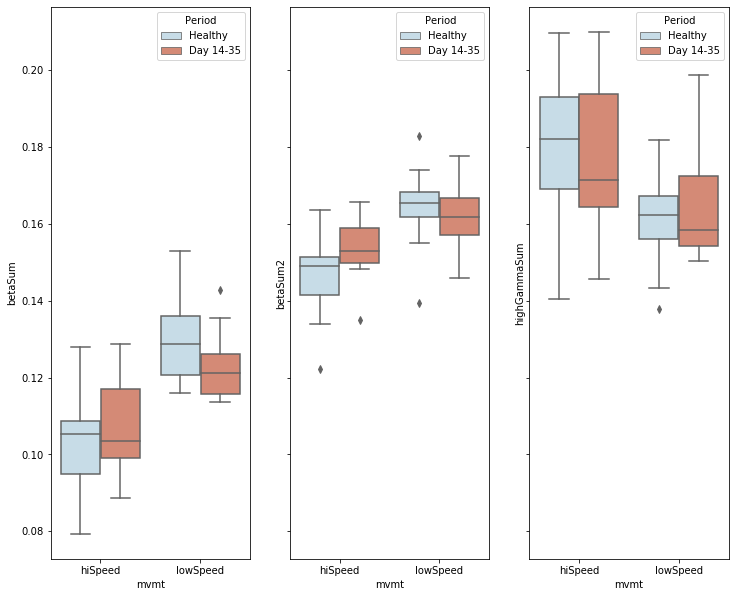

In [136]:
df = pd.read_csv(figFolder+'lfpForR_Post.csv')
df2 = df.groupby(['Period','Mouse','mvmt']).mean()
df2 = df2.reset_index()
# print(df2)
# def difAplly(row,fr):
#     if row.mvmt in ['hiSpeed','lowSpeed']:
#         low = float(df2[(df2.Mouse == row.Mouse)&(df2.Period == row.Period)&(df2.mvmt == 'lowSpeed')][fr].item())
#     else:
#         low = float(df2[(df2.Mouse == row.Mouse)&(df2.Period == row.Period)&(df2.mvmt == 'lowRot')][fr].item())
        
#     val = float(row[fr])
#     if low==0:
#         return None
#     else: #base <0 and val >0:
#         return (val-low)

# df2['diff_beta'] = df2.apply(lambda row: difAplly(row,'betaSum'),axis=1) 
# df2['diff_gamma'] = df2.apply(lambda row: difAplly(row,'gammaSum'),axis=1)    
# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='Period',y='betaSum',ax = ax[0],data=df2[df2.mvmt=='all'],order = ['Healthy','Day 14-35'])
#     sns.boxplot(x='Period',y='gammaSum',ax = ax[1],data=df2[df2.mvmt=='all'],order = ['Healthy','Day 14-35'])
# fig.savefig(figFolder+'figure5_lfpfullSess_bar_Post.svg',transparent=True,format='svg')

fig, ax = fig, ax = plt.subplots(1,3,figsize=(12.15,10.15),sharey='row')
with sns.color_palette(colorPallet3):
    sns.boxplot(x='mvmt',hue = 'Period',y='betaSum',ax = ax[0],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 14-35'])
    sns.boxplot(x='mvmt',hue = 'Period',y='highGammaSum',ax = ax[2],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 14-35'])
    sns.boxplot(x='mvmt',hue = 'Period',y='betaSum2',ax = ax[1],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 14-35'])

fig.savefig(figFolder+'figure5_speed_bar_post.png',transparent=True,format='png')

# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_beta',ax = ax[0],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_gamma',ax = ax[1],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_speed_bar_diff.svg',transparent=True,format='svg')


# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='betaSum',ax = ax[0],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='gammaSum',ax = ax[1],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_rot_bar.svg',transparent=True,format='svg')

# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_beta',ax = ax[0],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_gamma',ax = ax[1],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_rot_bar_diff.svg',transparent=True,format='svg')


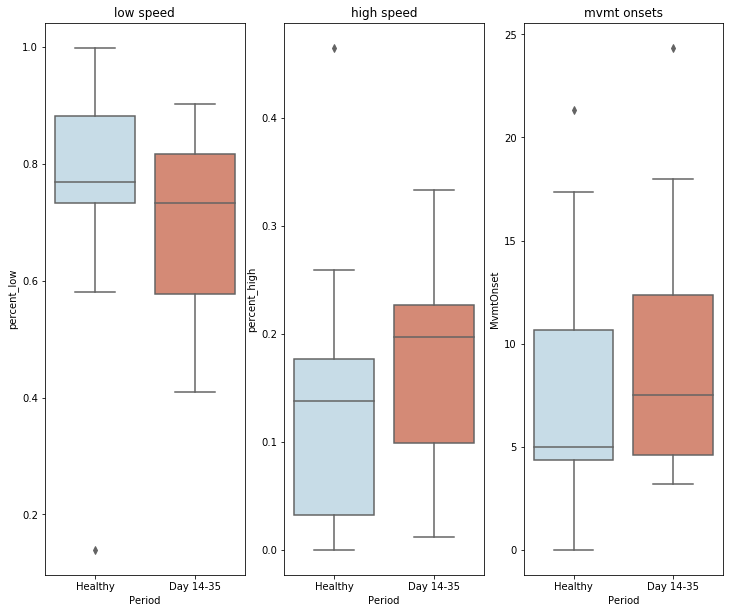

In [172]:
df = pd.read_csv('lineraVelocity_post.csv')
df = df[df.Drug == 'L-Dopa']
df = df[df.timeRange == 'full']
df['Period'] = df.Day.apply(lambda x: periodCalc(x))
df.to_csv(figFolder+'lineraVelocity_post2.csv')
df2 = df.groupby(['Period','Mouse']).mean()
df2 = df2.reset_index()

fig, ax = fig, ax = plt.subplots(1,3,figsize=(12.15,10.15))#,sharey='row')
with sns.color_palette(colorPallet3):
    sns.boxplot(x='Period',y='percent_low',ax = ax[0],data=df2,order = ['Healthy','Day 14-35'])
    sns.boxplot(x='Period',y='percent_high',ax = ax[1],data=df2,order = ['Healthy','Day 14-35'])
    sns.boxplot(x='Period',y='MvmtOnset',ax = ax[2],data=df2,order = ['Healthy','Day 14-35'])
    ax[0].set_title('low speed')
    ax[1].set_title('high speed')
    ax[2].set_title('mvmt onsets')
fig.savefig(figFolder+'speed_post_LDopa.png',transparent=True,format='png')


In [187]:
# df = df_normlizeByCol_meanPost
df = df_normlizeByCol_meanPre
# df.groupby(['mouse','period'])
periodsPre = {'Healthy':{'axis':0},'Day 14-35':{'axis':1}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periodsPre.keys():
    for c in conds:
        periodsPre[p][c] = np.zeros((87,1))
    for m in df[df.period == p].mouse.unique():
        for c in conds:
            try:
                te = np.array(df[(df.period == p)&(df.mouse == m)][c].tolist())
#                 print(te.shape)
                periodsPre[p][c] = np.concatenate((periodsPre[p][c],np.nanmean(te,axis=0).T),axis=1)                         
            except:
                print(m,c,p,te.shape)
                continue
for p in periodsPre.keys():
    for c in conds:
        periodsPre[p][c] = periodsPre[p][c][:,1:]



8803 highAC Healthy (1,)
0761 highC Day 14-35 (2,)
0761 hiSpeed Day 14-35 (2,)
1208 highC Day 14-35 (2,)
1236 highAC Day 14-35 (2,)
2980 highC Day 14-35 (2,)
8803 highC Day 14-35 (2,)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [188]:
df = df_normlizeByCol_meanPost
# df = df_normlizeByCol_meanPre
# df.groupby(['mouse','period'])
periodsPost = {'Healthy':{'axis':0},'Day 14-35':{'axis':1}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periodsPost.keys():
    for c in conds:
        periodsPost[p][c] = np.zeros((87,1))
    for m in df[df.period == p].mouse.unique():
        for c in conds:
            try:
                te = np.array(df[(df.period == p)&(df.mouse == m)][c].tolist())
#                 print(te.shape)
                periodsPost[p][c] = np.concatenate((periodsPost[p][c],np.nanmean(te,axis=0).T),axis=1)                         
            except:
                print(m,c,p,te.shape)
                continue
for p in periodsPost.keys():
    for c in conds:
        periodsPost[p][c] = periodsPost[p][c][:,1:]



1793 highAC Healthy (1,)
1793 highC Healthy (1,)
1793 hiSpeed Healthy (1,)
8430 highAC Healthy (1,)
1236 highAC Day 14-35 (2,)
1793 highAC Day 14-35 (2,)
1793 highC Day 14-35 (2,)
1793 hiSpeed Day 14-35 (2,)
8803 highAC Day 14-35 (2,)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


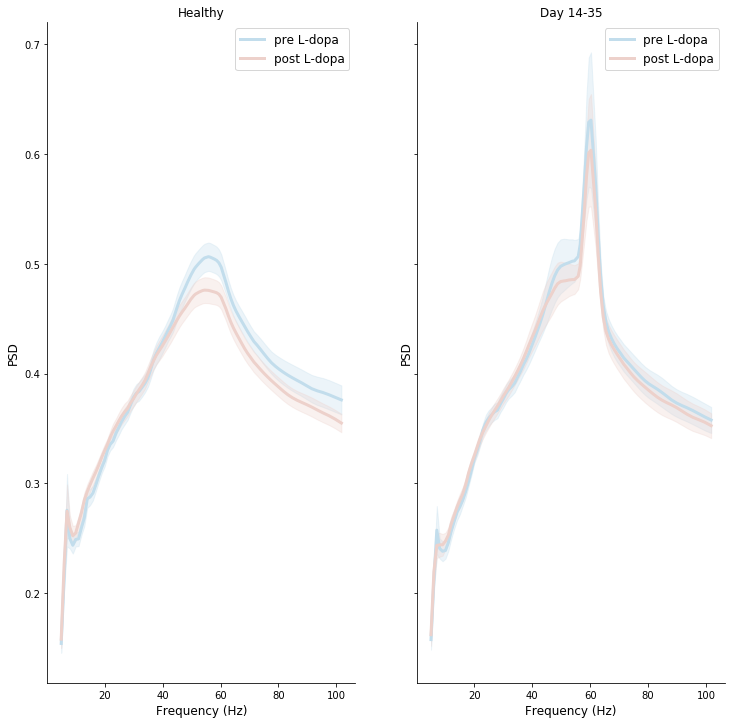

In [200]:
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,2,figsize=(12.15,12.15),sharey='row')
for ind, p in enumerate(periodsPre.keys()):
    hC = np.nanmean(periodsPre[p]['lowSpeed'],axis=1)*freq
    hS2 = np.nanstd(periodsPre[p]['lowSpeed'],axis=1)*freq/np.sqrt(periodsPre[p]['all'].shape[1])
       
    ax[ind].plot(freq,hC,color = colorsH[0], label='pre L-dopa',linewidth=3.0)
    ax[ind].fill_between(freq, hC-hS2, hC+hS2,color=colorsH[0],alpha=0.3)
    
    hC = np.nanmean(periodsPost[p]['lowSpeed'],axis=1)*freq
    hS2 = np.nanstd(periodsPost[p]['lowSpeed'],axis=1)*freq/np.sqrt(periodsPost[p]['all'].shape[1])
       
    ax[ind].plot(freq,hC,color = colorsL[0], label='post L-dopa',linewidth=3.0)
    ax[ind].fill_between(freq, hC-hS2, hC+hS2,color=colorsL[0],alpha=0.3)
#     ax.set_xlim(6,100)
    ax[ind].set_title(p)
#     ax.set_xlim(60,100)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[ind].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[ind].spines['right'].set_visible(False)
    ax[ind].spines['top'].set_visible(False)
    ax[ind].legend(fontsize=12)
# fig.savefig(figFolder+'lfpSpectromPost_LDOPA_lowSpeed_freq.png',transparent=True,format='png')
# ax.set_xlim(10,30)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess_zoomBeta.svg',transparent=True,format='svg')



In [186]:
periodsPre.keys()

dict_keys(['Healthy', 'Day 1-13', 'Day 14-35'])

In [271]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Post', mice=m, drug = b'Amphetamin')
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Post','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Post','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Post','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Post','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Post','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Post']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            Hs2 = Hs2.T
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByCol_meanPost_Amph = pd.DataFrame(specs)
df_normlizeByCol_meanPost_Amph = df_normlizeByCol_meanPost_Amph.T
# df.to_csv('specs_normlizeByRow_sum.csv')

  0%|          | 0/16 [00:00<?, ?it/s]/home/dana_z/ssd_2TB/6OHDA/IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value


cleaning up lfp data
cleaning up speed data


/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  6%|▋         | 1/16 [02:31<37:56, 151.74s/it]

cleaning up lfp data
cleaning up speed data


 12%|█▎        | 2/16 [05:33<37:30, 160.76s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [07:52<33:25, 154.29s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [08:48<24:57, 124.82s/it]

cleaning up lfp data
cleaning up speed data
found  34.0  outlier points
found  927582.0  outlier points


 31%|███▏      | 5/16 [11:39<25:24, 138.60s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [12:20<18:14, 109.40s/it]

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [15:21<19:36, 130.70s/it]

cleaning up lfp data
cleaning up speed data


 50%|█████     | 8/16 [17:59<18:31, 138.99s/it]

cleaning up lfp data
cleaning up speed data
found  144.0  outlier points


 56%|█████▋    | 9/16 [21:09<18:00, 154.42s/it]

cleaning up lfp data
cleaning up speed data
found  105.0  outlier points


 62%|██████▎   | 10/16 [23:50<15:37, 156.31s/it]

cleaning up lfp data
cleaning up speed data
found  17.0  outlier points


 69%|██████▉   | 11/16 [26:21<12:53, 154.71s/it]

cleaning up lfp data
cleaning up speed data


 75%|███████▌  | 12/16 [27:26<08:30, 127.71s/it]

cleaning up lfp data
cleaning up speed data
found  10.0  outlier points


 81%|████████▏ | 13/16 [30:41<07:24, 148.03s/it]

cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [33:02<04:51, 145.93s/it]

cleaning up lfp data
cleaning up speed data


 94%|█████████▍| 15/16 [35:07<02:19, 139.44s/it]

cleaning up lfp data
cleaning up speed data


100%|██████████| 16/16 [37:31<00:00, 140.74s/it]


In [272]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m, drug = b'Amphetamin')
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            Hs2 = Hs2.T
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByCol_meanPre_Amph = pd.DataFrame(specs)
df_normlizeByCol_meanPre_Amph = df_normlizeByCol_meanPre_Amph.T
# df.to_csv('specs_normlizeByRow_sum.csv')

  0%|          | 0/16 [00:00<?, ?it/s]/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


cleaning up lfp data
cleaning up speed data


  6%|▋         | 1/16 [00:30<07:32, 30.16s/it]

cleaning up lfp data
cleaning up speed data


 12%|█▎        | 2/16 [01:01<07:07, 30.56s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [01:38<07:01, 32.42s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [01:50<05:17, 26.44s/it]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  888231.0  outlier points


 31%|███▏      | 5/16 [02:26<05:21, 29.27s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [02:38<04:01, 24.15s/it]

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [03:15<04:09, 27.75s/it]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points


 50%|█████     | 8/16 [03:51<04:03, 30.45s/it]

cleaning up lfp data
cleaning up speed data


 56%|█████▋    | 9/16 [04:26<03:42, 31.74s/it]

cleaning up lfp data
cleaning up speed data
found  50.0  outlier points


 62%|██████▎   | 10/16 [05:03<03:19, 33.31s/it]

cleaning up lfp data
cleaning up speed data


 69%|██████▉   | 11/16 [05:49<03:05, 37.04s/it]

cleaning up lfp data
cleaning up speed data


 75%|███████▌  | 12/16 [06:11<02:09, 32.47s/it]

cleaning up lfp data
cleaning up speed data


 81%|████████▏ | 13/16 [06:59<01:52, 37.34s/it]

cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [07:34<01:12, 36.46s/it]

cleaning up lfp data
cleaning up speed data


 94%|█████████▍| 15/16 [07:56<00:32, 32.23s/it]

cleaning up lfp data
cleaning up speed data


100%|██████████| 16/16 [08:29<00:00, 31.82s/it]


In [277]:
df = df_normlizeByCol_meanPost_Amph
# df = df_normlizeByCol_meanPre_Amph
# df.groupby(['mouse','period'])
periods = {'Healthy':{'axis':0},'Day 1-13':{'axis':1},'Day 14-35':{'axis':2}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periods.keys():
    for c in conds:
        periods[p][c] = np.zeros((87,1))
    for m in df[df.period == p].mouse.unique():
        for c in conds:
            try:
                te = np.array(df[(df.period == p)&(df.mouse == m)][c].tolist())
#                 print(te.shape)
                periods[p][c] = np.concatenate((periods[p][c],np.nanmean(te,axis=0).T),axis=1)                         
            except:
                print(m,c,p,te.shape)
                continue
for p in periods.keys():
    for c in conds:
        periods[p][c] = periods[p][c][:,1:]



1253 highAC Healthy (1,)
4539 lowSpeed Healthy (2,)
1222 highC Day 14-35 (2,)
1793 highC Day 14-35 (2,)
8430 highC Day 14-35 (2,)
8815 highC Day 14-35 (2,)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [281]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'Sess'})
df

,Sess,mouse,day,period,all,highAC,highC,lowRot,lowSpeed,hiSpeed
0,0761_BaselineA,0761,0,Healthy,"[[0.02876768465526848, 0.06463936762839047, 0....","[[0.028930441092292022, 0.04550464614099855, 0...","[[0.026921176987748947, 0.0722995052029462, 0....","[[0.03157241669526732, 0.0606967539984188, 0.0...","[[0.02963612775865243, 0.06022399785354268, 0....","[[0.030819023614987857, 0.049826756240077215, ..."
1,0761_day14A,0761,14,Day 14-35,"[[0.017636786404003547, 0.07119876102346331, 0...","[[0.015498422715604162, 0.05579742974736276, 0...","[[0.0174630576835836, 0.07574284780549449, 0.0...","[[0.018511470047013978, 0.07745104335273922, 0...","[[0.0172182043039278, 0.04585282891684846, 0.0...","[[0.01743575145080504, 0.07411932431911669, 0...."
2,0761_day31A,0761,31,Day 14-35,"[[0.013457495647732354, 0.032516934385271964, ...","[[0.013282123634030845, 0.034270861445472915, ...","[[0.017636569488303753, 0.020830155420287398, ...","[[0.01487167497963564, 0.026963073496501035, 0...","[[0.018868589256680834, 0.028845455846950963, ...","[[0.013124559699016089, 0.03351687708771675, 0..."
3,1208_BaselineA,1208,0,Healthy,"[[0.02151405813410194, 0.027889262932355822, 0...","[[0.021662941011678746, 0.026775344522764612, ...","[[0.013979160717044622, 0.015155762072182841, ...","[[0.021673055885983224, 0.03040632103353184, 0...","[[0.022509796652593266, 0.03367432355028378, 0...","[[0.021570474049997384, 0.026444448032140504, ..."
4,1208_day15A,1208,15,Day 14-35,"[[0.02190567698078864, 0.025951991808510176, 0...","[[0.022183900093437608, 0.02548674629640758, 0...","[[0.02289534848258643, 0.027414104087293063, 0...","[[0.02181481859957766, 0.027712014245423938, 0...","[[0.021495891055340503, 0.028274451767647243, ...","[[0.022083614494287012, 0.025526551599904274, ..."
5,1208_day30A,1208,30,Day 14-35,"[[0.022274765010398892, 0.024071326023251544, ...","[[0.02264901213287174, 0.024582774362347144, 0...","[[0.034098364870067434, 0.0428899762341972, 0....","[[0.023850027518887904, 0.02313170016111525, 0...","[[0.02273520252287103, 0.02412832718737113, 0....","[[0.02348979237198665, 0.0251680278315685, 0.0..."
6,1222_BaselineA,1222,0,Healthy,"[[0.05195676641707478, 0.04705546357774312, 0....","[[0.057296053934703606, 0.042291278287605115, ...","[[0.04379850445201092, 0.07502843296671571, 0....","[[0.04275316130629483, 0.04980608015104755, 0....","[[0.04761407864043351, 0.04872102827505164, 0....","[[0.05600936565833622, 0.04324247307290628, 0...."
7,1222_day15A,1222,15,Day 14-35,"[[0.02102743964504221, 0.08952123296884675, 0....","[[0.021677153012162984, 0.0948583252648339, 0....","[[0.017747416930139624, 0.0588694718956549, 0....","[[0.015953664273242147, 0.057606934050913244, ...","[[0.0310596608940062, 0.07242228130500057, 0.0...","[[0.020746146514202028, 0.07314227269627042, 0..."
8,1222_day32A,1222,32,Day 14-35,"[[0.020605211915185002, 0.07292698875613411, 0...","[[0.020845749437095027, 0.07384683417351495, 0...",NaN,"[[0.01930934649173269, 0.08143295369631376, 0....","[[0.02236266931329545, 0.07912060478003215, 0....","[[0.019405256806550444, 0.0672862429631134, 0...."
9,1231_BaselineA,1231,0,Healthy,"[[0.022729885870271627, 0.06185686331149055, 0...","[[0.02201927109714879, 0.03554960926123893, 0....","[[0.024140142967591104, 0.06827480946213078, 0...","[[0.022080967077039937, 0.06250840255566922, 0...","[[0.023797560751384148, 0.06547919910667989, 0...","[[0.019476115980636866, 0.04479704855527559, 0..."


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


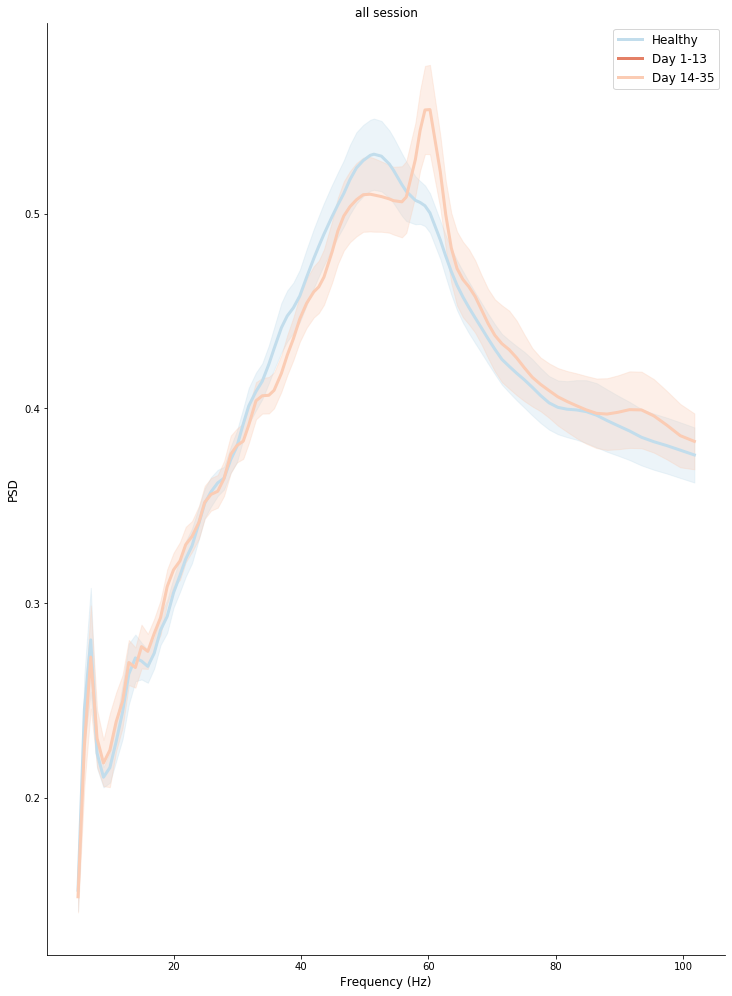

In [282]:
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,1,figsize=(12.15,17.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['lowSpeed'],axis=1)*freq
    hS2 = np.nanstd(periods[p]['lowSpeed'],axis=1)*freq/np.sqrt(periods[p]['all'].shape[1])
       
    ax.plot(freq,hC,color = colorsH[ind], label=p,linewidth=3.0)
    ax.fill_between(freq, hC-hS2, hC+hS2,color=colorsH[ind],alpha=0.3)
#     ax.set_xlim(6,100)
    ax.set_title('all session')
#     ax.set_xlim(60,100)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax.set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax.set_xlabel('Frequency (Hz)',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(fontsize=12)
fig.savefig(figFolder+'lfpSpectromPost_LDOPA_lowSpeed_freq.png',transparent=True,format='png')
# ax.set_xlim(10,30)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess_zoomBeta.svg',transparent=True,format='svg')



In [233]:
# df = df_normlizeByCol_meanPost_Saline
# df.reset_index(inplace=True)
# df = df.rename(columns = {'index':'Sess'})
# df


# te = np.array(df.iloc[0]['hiSpeed'])
# np.sum(te)
Hs.shape

(1815677,)

In [283]:
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

beta = (freq>10)&(freq<16)
beta2 = (freq>15)&(freq<25)
gamma =(freq>40)&(freq<60)
highGamma = (freq>60)&(freq<100)
highGamma2 = (freq>80)&(freq<100)

# print(periods[p]['hiSpeed'].shape,np.nanmean(periods[p]['hiSpeed'][beta],axis=0).shape)
df2 = pd.DataFrame(columns = ['Period','Mouse','sess','mvmt','beta','gamma'])
# # fig, ax = plt.subplots(2,3,figsize=(12.15,17.15),sharey='row')
for row in range(len(df)):
    for mv in ['highAC', 'highC', 'lowRot', 'lowSpeed', 'hiSpeed','all']:
        try:
            te = np.array(df.iloc[row][mv])
            df3 = pd.DataFrame({'Period':df.iloc[row]['period'],'Mouse':df.iloc[row]['mouse'],'mvmt':mv,'sess':df.iloc[row]['Sess'],
                                'beta':np.nanmean(te[0,beta],axis=0),
                                'beta2':np.nanmean(te[0,beta2],axis=0),
                               'gamma':np.nanmean(te[0,gamma],axis=0),
                               'highGamma':np.nanmean(te[0,highGamma],axis=0),
                                'highGamma2':np.nanmean(te[0,highGamma2],axis=0),
                               'betaSum':np.nansum(te[0,beta],axis=0),
                                'betaSum2':np.nansum(te[0,beta2],axis=0),
                               'highGammaSum':np.nansum(te[0,highGamma],axis=0),
                                'highGammaSum2':np.nansum(te[0,highGamma2],axis=0),
                               'gammaSum':np.nansum(te[0,gamma],axis=0)},index=[0])
            df2 = pd.concat([df3,df2])
        except: 
            print(df.iloc[row]['Sess'],mv)

df2['ratio'] = df2.apply(lambda x: x.beta/x.gamma, axis = 1)
df2['ratio_High'] = df2.apply(lambda x: x.beta/x.highGamma, axis = 1)
# df['diff'] = 
df2.to_csv(figFolder+'lfpForR_Post_Amph.csv')
df2.head()

1222_day32A highC
1253_BaselineA highAC
1793_day30A highC
4539_BaselineA lowSpeed
8430_day30A highC
8815_day30A highC


,Period,Mouse,mvmt,sess,beta,beta2,gamma,highGamma,highGamma2,betaSum,betaSum2,highGammaSum,highGammaSum2,gammaSum,ratio,ratio_High
0,Day 14-35,8815,all,8815_day30A,0.023439,0.016035,0.008135,0.005002,0.003896,0.140634,0.160350,0.150052,0.046747,0.162707,2.881133,4.686179
0,Day 14-35,8815,hiSpeed,8815_day30A,0.024817,0.016081,0.007693,0.004789,0.003740,0.148899,0.160813,0.143678,0.044879,0.153861,3.225841,5.181707
0,Day 14-35,8815,lowSpeed,8815_day30A,0.019328,0.016105,0.009379,0.005604,0.004341,0.115970,0.161047,0.168123,0.052095,0.187584,2.060774,3.448974
0,Day 14-35,8815,lowRot,8815_day30A,0.020865,0.015969,0.008966,0.005431,0.004230,0.125189,0.159688,0.162932,0.050763,0.179317,2.327146,3.841739
0,Day 14-35,8815,highAC,8815_day30A,0.025363,0.016322,0.007454,0.004571,0.003601,0.152179,0.163215,0.137145,0.043218,0.149087,3.402469,5.548114


In [284]:
df2 =pd.read_csv(figFolder+'lfpForR_Pre_Amph.csv')
df =pd.read_csv(figFolder+'lfpForR_Post_Amph.csv')
df3 = df2.merge(df,on=['sess','mvmt','Period'])
df3.to_csv(figFolder+'lfpForR_Amph.csv')
df4 = df3[['Period','Mouse_x','mvmt','sess','betaSum2_x','betaSum2_y']]
df4 = df4[df4.mvmt.isin(['hiSpeed','lowSpeed'])]

def difAplly(row,fr):
    try: 
        if row.mvmt in ['hiSpeed','lowSpeed']:
            low = float(df4[(df4.sess == row.sess)&(df4.Period == row.Period)&(df4.mvmt == 'hiSpeed')][fr].item())
        val = float(row[fr])
    except:
        return None
    if low==0:
        return None
    else: #base <0 and val >0:
        return (val-low)

df4['diff_pre'] = df4.apply(lambda row: difAplly(row,'betaSum2_x'),axis=1)    
df4['diff_post'] = df4.apply(lambda row: difAplly(row,'betaSum2_y'),axis=1)

df4

,Period,Mouse_x,mvmt,sess,betaSum2_x,betaSum2_y,diff_pre,diff_post
1,Day 14-35,8815,hiSpeed,8815_day30A,0.159633,0.160813,0.000000,0.000000
2,Day 14-35,8815,lowSpeed,8815_day30A,0.171568,0.161047,0.011936,0.000234
6,Day 14-35,8815,hiSpeed,8815_day15A,0.150665,0.162123,0.000000,0.000000
7,Day 14-35,8815,lowSpeed,8815_day15A,0.164129,0.156113,0.013464,-0.006010
12,Healthy,8815,hiSpeed,8815_BaselineA,0.169029,0.172160,0.000000,0.000000
...,...,...,...,...,...,...,...,...
239,Day 14-35,761,lowSpeed,0761_day31A,0.162054,0.138108,-0.005652,0.004739
243,Day 14-35,761,hiSpeed,0761_day14A,0.176601,0.139192,0.000000,0.000000
244,Day 14-35,761,lowSpeed,0761_day14A,0.166417,0.148513,-0.010183,0.009321
249,Healthy,761,hiSpeed,0761_BaselineA,0.153560,0.140693,0.000000,0.000000


In [285]:
df4.to_csv(figFolder+'lfpForR_Amph2.csv')

In [8]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)#, drug = b'Amphetamin')
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            rot = highAC+highC
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            Hs2 = Hs2.T
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed','rot']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByCol_mean = pd.DataFrame(specs)
df_normlizeByCol_mean = df_normlizeByCol_mean.T
# df.to_csv('specs_normlizeByRow_sum.csv')

  0%|          | 0/16 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  6%|▋         | 1/16 [02:14<33:35, 134.36s/it]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
found  17.0  outlier points


 12%|█▎        | 2/16 [04:42<32:17, 138.43s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [07:41<32:38, 150.63s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [08:19<23:22, 116.89s/it]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  888231.0  outlier points
found  481139.0  outlier points


 31%|███▏      | 5/16 [10:56<23:38, 128.99s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [11:35<17:00, 102.04s/it]

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [14:30<18:35, 123.91s/it]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points
found  3.0  outlier points


 50%|█████     | 8/16 [17:11<18:00, 135.06s/it]

cleaning up lfp data
cleaning up speed data


 56%|█████▋    | 9/16 [19:49<16:33, 141.88s/it]

cleaning up lfp data
cleaning up speed data
found  50.0  outlier points


 62%|██████▎   | 10/16 [22:40<15:04, 150.70s/it]

cleaning up lfp data
cleaning up speed data
found  29.0  outlier points


 69%|██████▉   | 11/16 [25:59<13:44, 164.94s/it]

cleaning up lfp data
cleaning up speed data


 75%|███████▌  | 12/16 [28:58<11:16, 169.24s/it]

cleaning up lfp data
cleaning up speed data


 81%|████████▏ | 13/16 [32:18<08:55, 178.36s/it]

cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [34:49<05:40, 170.21s/it]

cleaning up lfp data
cleaning up speed data
8803_day6 34


 94%|█████████▍| 15/16 [37:09<02:41, 161.28s/it]

cleaning up lfp data
cleaning up speed data
8815_day6 34


100%|██████████| 16/16 [39:33<00:00, 148.36s/it]


In [31]:
df = df_normlizeByCol_mean
# df = df_normlizeByCol_meanPre_Amph
# df.groupby(['mouse','period'])
periods = {'Healthy':{'axis':0},'Day 1-13':{'axis':1},'Day 14-35':{'axis':2}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','rot','all']

for p in periods.keys():
    for c in conds:
        periods[p][c] = np.zeros((87,1))
    for m in df[df.period == p].mouse.unique():
        for c in conds:
            try:
                te = np.array(df[(df.period == p)&(df.mouse == m)][c].tolist())
#                 print(te.shape)
                periods[p][c] = np.concatenate((periods[p][c],np.nanmean(te,axis=0).T),axis=1)                         
            except:
                print(m,c,p,te.shape)
                continue
for p in periods.keys():
    for c in conds:
        periods[p][c] = periods[p][c][:,1:]



8803 highAC Healthy (3,)
1208 highC Day 1-13 (5,)
2981 highAC Day 1-13 (6,)
4539 highAC Day 1-13 (12,)
4539 highC Day 1-13 (12,)
4539 rot Day 1-13 (12,)
7584 highAC Day 1-13 (12,)
7584 highC Day 1-13 (12,)
7584 rot Day 1-13 (12,)
7909 highAC Day 1-13 (12,)
7909 highC Day 1-13 (12,)
7909 hiSpeed Day 1-13 (12,)
7909 rot Day 1-13 (12,)
0761 highC Day 14-35 (4,)
0761 hiSpeed Day 14-35 (4,)
1208 highC Day 14-35 (5,)
1236 highAC Day 14-35 (5,)
2980 highC Day 14-35 (5,)
4539 highAC Day 14-35 (4,)
4539 highC Day 14-35 (4,)
4539 rot Day 14-35 (4,)
7584 highAC Day 14-35 (2,)
7584 highC Day 14-35 (2,)
7584 rot Day 14-35 (2,)
7909 highAC Day 14-35 (4,)
7909 highC Day 14-35 (4,)
7909 rot Day 14-35 (4,)
8803 highC Day 14-35 (4,)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


In [11]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'Sess'})
df

,Sess,mouse,day,period,all,highAC,highC,lowRot,lowSpeed,hiSpeed,rot
0,0761_BaselineA,0761,0,Healthy,"[[0.026937597856671294, 0.039606724431787664, ...","[[0.015334746927216668, 0.025047390304927433, ...","[[0.02152817333132848, 0.03140060220470342, 0....","[[0.030080730572367605, 0.04428542979826004, 0...","[[0.02941381885052106, 0.04352431763246545, 0....","[[0.01394515585597038, 0.01948187735739016, 0....","[[0.016984355030913875, 0.026739556991112107, ..."
1,0761_BaselineL,0761,0,Healthy,"[[0.028317944575055945, 0.042404741343348366, ...","[[0.017175769082858994, 0.03008794858631673, 0...","[[0.02024810813837574, 0.03613063664659965, 0....","[[0.03251517431718947, 0.04660735134274601, 0....","[[0.032633792249092235, 0.047944465932890985, ...","[[0.015899546334882594, 0.02312272458289229, 0...","[[0.017627535826570097, 0.030976485124416843, ..."
2,0761_BaselineS,0761,0,Healthy,"[[0.025604036096745934, 0.040613298984899585, ...","[[0.018151913956442143, 0.032198904948375844, ...","[[0.020641377127176973, 0.03583771182228051, 0...","[[0.0313811331062335, 0.04422470570178386, 0.0...","[[0.030367619906178117, 0.04517285254535004, 0...","[[0.018355916439210085, 0.029810530193504013, ...","[[0.018832110648843724, 0.03319313713024375, 0..."
3,0761_day1,0761,1,Day 1-13,"[[0.03029638015657264, 0.04370467652972099, 0....","[[0.016654866847566202, 0.031516705070738255, ...","[[0.027168830998745976, 0.03868191071369943, 0...","[[0.03549183848397926, 0.04829577162249925, 0....","[[0.034686448288155085, 0.04820219698752827, 0...","[[0.012775571148896714, 0.0211188638789872, 0....","[[0.01780602578345219, 0.03230121321483646, 0...."
4,0761_day10,0761,10,Day 1-13,"[[0.03232579724128348, 0.044394029432878665, 0...","[[0.018798173218869042, 0.027129806183325174, ...","[[0.02922983661437048, 0.03417746875509607, 0....","[[0.03595818137495213, 0.047839785777122334, 0...","[[0.035431403515385165, 0.04807538527882928, 0...","[[0.01729512137647685, 0.0230893673445883, 0.0...","[[0.01925684084751446, 0.027439683386675278, 0..."
...,...,...,...,...,...,...,...,...,...,...,...
205,8815_day2,8815,2,Day 1-13,"[[0.030633934610500152, 0.03812544275709151, 0...","[[0.033870030939494665, 0.033247935255767684, ...","[[0.018868834668442788, 0.0338308521285831, 0....","[[0.0318723597713264, 0.04039862305953711, 0.0...","[[0.031395622470692615, 0.04012279257646909, 0...","[[0.02735499876238924, 0.03224404065010677, 0....","[[0.026428255554773475, 0.03353710795620243, 0..."
206,8815_day30A,8815,30,Day 14-35,"[[0.029709471755341138, 0.03756162958831144, 0...","[[0.038618751735773844, 0.04787599804929012, 0...","[[0.01969704923241186, 0.04471202290593525, 0....","[[0.02761709832339242, 0.037121688925973395, 0...","[[0.026707070943332512, 0.036632198699880665, ...","[[0.03858321438347195, 0.04132885153433812, 0....","[[0.03781644438247895, 0.04774184096048155, 0...."
207,8815_day34L,8815,34,Day 14-35,"[[0.031932283376201985, 0.03439057942215082, 0...","[[0.032199991716480525, 0.03489771579851191, 0...","[[0.028403964314384585, 0.030523573537765275, ...","[[0.030245634234714717, 0.03417477644013087, 0...","[[0.027982140590906677, 0.034239144109448026, ...","[[0.035746651883022895, 0.03517213253013865, 0...","[[0.03032741360843922, 0.032739953967179644, 0..."
208,8815_day4,8815,4,Day 1-13,"[[0.03983152776919577, 0.04185539691257952, 0....","[[0.025462524716821082, 0.03404653370128897, 0...","[[0.023449505458744097, 0.044301997233991725, ...","[[0.04326036695833673, 0.042629498345019466, 0...","[[0.04323537510900435, 0.04265300119263958, 0....","[[0.02556136671184061, 0.039152321240596255, 0...","[[0.025062475617618814, 0.036084611047889625, ..."


In [48]:
a = (freq<60)|(freq>61)
print(a.shape,a)

(87,) [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


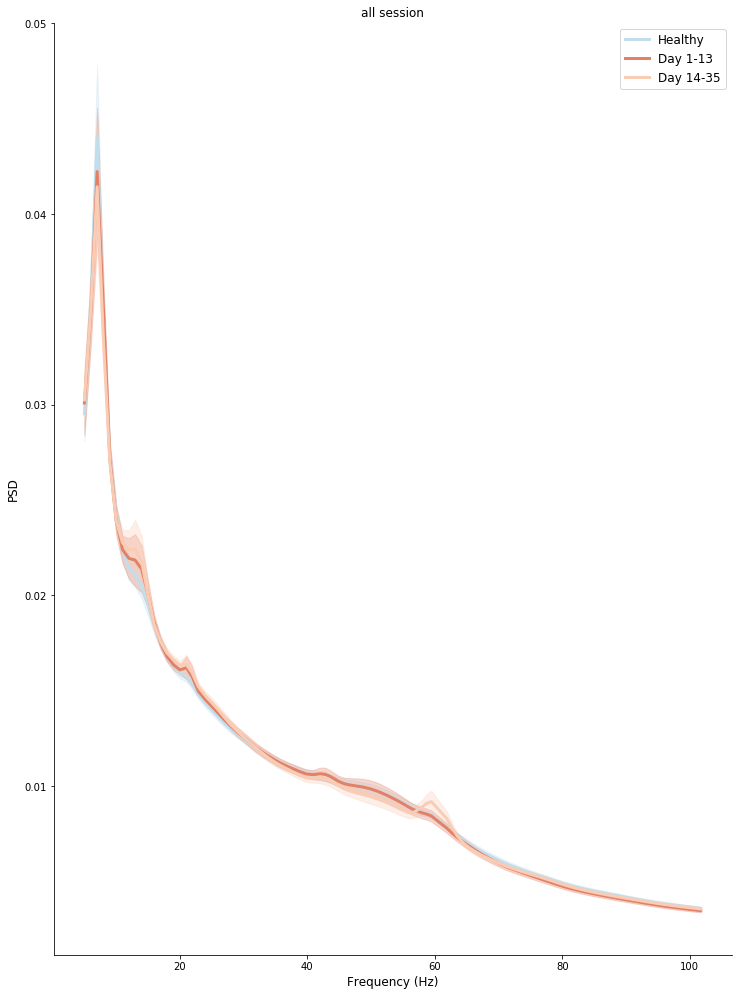

In [55]:
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,1,figsize=(12.15,17.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['all'][a],axis=1)
    hS2 = np.nanstd(periods[p]['all'][a],axis=1)/np.sqrt(periods[p]['all'][a].shape[1])
       
    ax.plot(freq[a],hC,color = colorsH[ind], label=p,linewidth=3.0)
    ax.fill_between(freq[a], hC-hS2, hC+hS2,color=colorsH[ind],alpha=0.3)
#     ax.set_xlim(55,65)
    ax.set_title('all session')
#     ax.set_xlim(60,100)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax.set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax.set_xlabel('Frequency (Hz)',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(fontsize=12)
# fig.savefig(figFolder+'lfpSpectromPost_LDOPA_lowSpeed_freq.png',transparent=True,format='png')
# ax.set_xlim(10,30)
fig.savefig(figFolder+'lfpSpectromPeriod_all.svg',transparent=True,format='svg')



In [24]:
def difAplly(row,fr):
    if row.mvmt in ['hiSpeed','lowSpeed']:
        low = float(df2[(df2.sess == row.sess)&(df2.Period == row.Period)&(df2.mvmt == 'lowSpeed')][fr].item())
    else:
        low = float(df2[(df2.sess == row.sess)&(df2.Period == row.Period)&(df2.mvmt == 'lowRot')][fr].item())
    val = float(row[fr])
    if low==0:
        return None
    else: #base <0 and val >0:
        return (low-val)

In [25]:
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

beta = (freq>10)&(freq<16)
beta2 = (freq>15)&(freq<25)
gamma =(freq>40)&(freq<60)
highGamma = (freq>60)&(freq<100)
highGamma2 = (freq>80)&(freq<100)

# print(periods[p]['hiSpeed'].shape,np.nanmean(periods[p]['hiSpeed'][beta],axis=0).shape)
df2 = pd.DataFrame(columns = ['Period','Mouse','sess','mvmt','beta','gamma'])
# # fig, ax = plt.subplots(2,3,figsize=(12.15,17.15),sharey='row')
for row in range(len(df)):
    for mv in ['highAC', 'highC', 'lowRot', 'lowSpeed', 'hiSpeed','rot','all']:
        try:
            te = np.array(df.iloc[row][mv])
            df3 = pd.DataFrame({'Period':df.iloc[row]['period'],'Mouse':df.iloc[row]['mouse'],'mvmt':mv,'sess':df.iloc[row]['Sess'],
                                'beta':np.nanmean(te[0,beta],axis=0),
                                'beta2':np.nanmean(te[0,beta2],axis=0),
                               'gamma':np.nanmean(te[0,gamma],axis=0),
                               'highGamma':np.nanmean(te[0,highGamma],axis=0),
                                'highGamma2':np.nanmean(te[0,highGamma2],axis=0),
                               'betaSum':np.nansum(te[0,beta],axis=0),
                                'betaSum2':np.nansum(te[0,beta2],axis=0),
                               'highGammaSum':np.nansum(te[0,highGamma],axis=0),
                                'highGammaSum2':np.nansum(te[0,highGamma2],axis=0),
                               'gammaSum':np.nansum(te[0,gamma],axis=0)},index=[0])
            df2 = pd.concat([df3,df2])
        except: 
            print(df.iloc[row]['Sess'],mv)

df2['ratio'] = df2.apply(lambda x: x.betaSum/x.gammaSum, axis = 1)
df2['ratio_High'] = df2.apply(lambda x: x.betaSum/x.highGammaSum, axis = 1)
df2['diffBeta'] = df2.apply(lambda x: difAplly(x,'betaSum'), axis = 1)

df2.to_csv(figFolder+'lfpForR.csv')
df2 = df2.groupby(['Mouse','Period','mvmt']).mean()
df2 = df2.reset_index()
df2.to_csv(figFolder+'lfpForR_grouped.csv')

0761_day31A highC
0761_day35L highC
0761_day35L hiSpeed
1208_day2 highC
1208_day30A highC
1208_day34L highC
1236_day15A highAC
1236_day19L highAC
1236_day30A highAC
2980_day19L highC
2981_day2 highAC
4539_day1 highAC
4539_day1 highC
4539_day1 rot
4539_day10 highAC
4539_day10 highC
4539_day10 rot
4539_day11 highAC
4539_day11 highC
4539_day11 rot
4539_day12 highAC
4539_day12 highC
4539_day12 rot
4539_day13 highAC
4539_day13 highC
4539_day13 rot
4539_day14 highAC
4539_day14 highC
4539_day14 rot
4539_day2 highAC
4539_day2 highC
4539_day2 rot
4539_day3 highAC
4539_day3 highC
4539_day3 rot
4539_day4 highAC
4539_day4 highC
4539_day4 rot
4539_day5 highAC
4539_day5 highC
4539_day5 rot
4539_day6 highAC
4539_day6 highC
4539_day6 rot
4539_day7 highAC
4539_day7 highC
4539_day7 rot
4539_day8 highAC
4539_day8 highC
4539_day8 rot
4539_day9 highAC
4539_day9 highC
4539_day9 rot
7584_day1 highAC
7584_day1 highC
7584_day1 rot
7584_day10 highAC
7584_day10 highC
7584_day10 rot
7584_day11 highAC
7584_day11 h

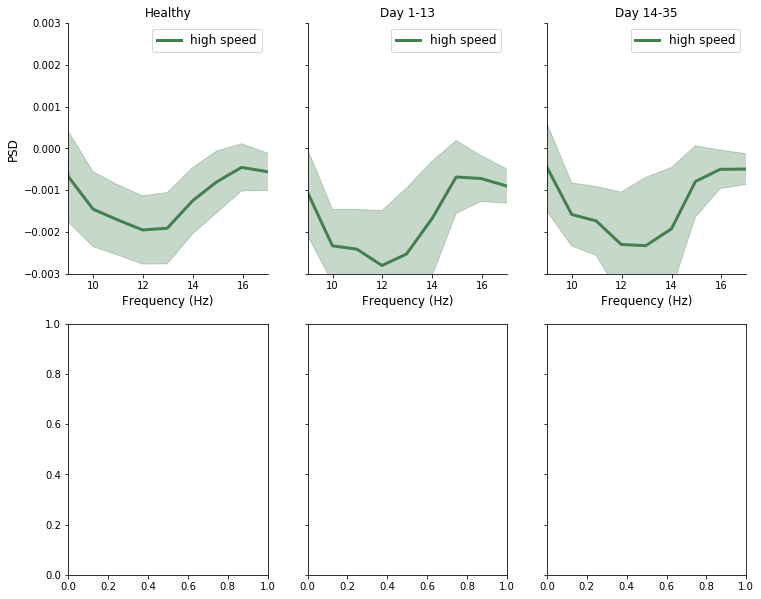

In [36]:
#periods = {'Healthy':{'axis':0},'Day 1-4':{'axis':1},'Day 5-12':{'axis':2},'Day 13-20':{'axis':3},'One Month':{'axis':4}}
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(2,3,figsize=(12.15,10.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['hiSpeed'],axis=1) - np.nanmean(periods[p]['lowSpeed'],axis=1)
    hS2 = np.sqrt(np.nanstd(periods[p]['hiSpeed'],axis=1)**2+np.nanstd(periods[p]['lowSpeed'],axis=1)**2)/np.sqrt(2)
    hS2 = hS2/np.sqrt(periods[p]['hiSpeed'].shape[1])
       
    ax[0,ind].plot(freq,hC,color = colorsH[4], label='high speed',linewidth=3.0)
    ax[0,ind].fill_between(freq, hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
#     ax[0,ind].plot(freq,lC,color = colorsL[4], label='low speed',linewidth=3.0)
#     ax[0,ind].fill_between(freq, lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
    ax[0,ind].set_xlim(6,100)
#     ax[0,ind].set_yscale('log')
    ax[0,ind].set_title(p)
#    ax[0,ind].set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[0,0].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[0,ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[0,ind].spines['right'].set_visible(False)
    ax[0,ind].spines['top'].set_visible(False)
    ax[0,ind].legend(fontsize=12)
    
#     hC = np.nanmean(periods[p]['highC'],axis=1)
#     hS2 = np.nanstd(periods[p]['highC'],axis=1)/np.sqrt(periods[p]['highC'].shape[1])
#     hAC = np.nanmean(periods[p]['highAC'],axis=1)
#     hS2A = np.nanstd(periods[p]['highAC'],axis=1)/np.sqrt(periods[p]['highAC'].shape[1])
#     lC = np.nanmean(periods[p]['lowRot'],axis=1)
#     lS2 = np.nanstd(periods[p]['lowRot'],axis=1)/np.sqrt(periods[p]['lowRot'].shape[1])
       
#     ax[1,ind].plot(freq,hC,color = colorsH[4], label='high Contralateral rot',linewidth=3.0)
#     ax[1,ind].fill_between(freq, hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
#     ax[1,ind].plot(freq,hAC,color = colorsH2[4], label='high Ipsiliteral rot',linewidth=3.0)
#     ax[1,ind].fill_between(freq, hAC-hS2A, hAC+hS2A,color=colorsH2[4],alpha=0.3)
#     ax[1,ind].plot(freq,lC,color = colorsL[4], label='low rotation',linewidth=3.0)
#     ax[1,ind].fill_between(freq, lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
#     ax[1,ind].set_xlim(6,100)
#     ax[1,ind].set_yscale('log')
#     ax[1,ind].set_title(p)
# #    ax[0,ind].set_xlim(9,15)
# #    ax[0,ind].set_ylim(0.015,0.03)
#     ax[1,0].set_ylabel('PSD',fontsize=12)
#     #ax[0,ind].axes.get_yaxis().set_ticks([])
#     ax[1,ind].set_xlabel('Frequency (Hz)',fontsize=12)
#     ax[1,ind].spines['right'].set_visible(False)
#     ax[1,ind].spines['top'].set_visible(False)
#     ax[1,ind].legend(fontsize=12)
# #fig.savefig(figFolder+'lfpSpectromPeriod.png',transparent=True,format='png')
# fig.savefig(figFolder+'figure5_lfpSpectromPeriod.svg',transparent=True,format='svg')

#fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')
# for ind, p in enumerate(periods.keys()):
    ax[0,ind].set_xlim(9,17)
    ax[0,ind].set_ylim(-0.003,0.003)
#     ax[1,ind].set_xlim(9,17)
#     ax[1,ind].set_ylim(0.015,0.03)
# #     ax[0,ind].set_ylim(0,0.032)
# #     ax[1,ind].set_ylim(0,0.032)
# #fig.savefig(figFolder+'lfpSpectromPeriodZoomBeta.png',transparent=True,format='png')
# fig.savefig(figFolder+'figure5_ZoomBeta.svg',transparent=True,format='svg')
# for ind, p in enumerate(periods.keys()):
#     ax[0,ind].set_xlim(40,60)
#     ax[0,ind].set_ylim(0.008,0.012)
#     ax[1,ind].set_xlim(40,60)
#     ax[1,ind].set_ylim(0.008,0.012)
# #     ax[0,ind].set_ylim(0,0.02)
# #     ax[1,ind].set_ylim(0,0.02)
# fig.savefig(figFolder+'lfpSpectromPeriodZoomGamma.svg',transparent=True,format='svg')
# fig.savefig(figFolder+'figure5_lfpZoomGamma_log.svg',transparent=True,format='svg')
# for ind, p in enumerate(periods.keys()):
#     ax[0,ind].set_xlim(5,10)
#     ax[1,ind].set_xlim(5,10)
# #     ax[0,ind].set_ylim(0.03,0.05)
# #     ax[1,ind].set_ylim(0.03,0.05)
# fig.savefig(figFolder+'lfpSpectromPeriodZoomTheta.svg',transparent=True,format='svg')



In [34]:
hC

array([-5.63684048e-03, -7.29162017e-03,  1.80811030e-04,  1.64224330e-03,
       -4.39990242e-04, -1.57940939e-03, -1.73338651e-03, -2.29787899e-03,
       -2.32538315e-03, -1.92089655e-03, -7.90373008e-04, -5.00123892e-04,
       -4.93583928e-04, -4.55974624e-04, -5.92263316e-04, -4.05339510e-04,
       -2.60857966e-04, -1.77295990e-04, -1.37095488e-04,  7.23563732e-05,
        3.25155524e-04,  4.02320404e-04,  3.37419628e-04,  5.81558313e-04,
        8.17477237e-04,  8.41857826e-04,  6.54083588e-04,  5.67649756e-04,
        5.77689683e-04,  6.57108963e-04,  6.93037018e-04,  6.68877036e-04,
        5.82949946e-04,  5.58330126e-04,  5.77573927e-04,  5.98480054e-04,
        6.18190258e-04,  5.77248709e-04,  5.63789910e-04,  5.65130010e-04,
        5.80238190e-04,  5.86029303e-04,  6.11752704e-04,  6.48649375e-04,
        6.64399154e-04,  6.53874451e-04,  6.40110366e-04,  6.23897621e-04,
        5.54079634e-04,  4.69777480e-04,  4.31939101e-04,  3.43043571e-04,
        2.68155635e-04,  

/home/dana_z/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 62.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dana_z/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 52.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dana_z/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 45.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


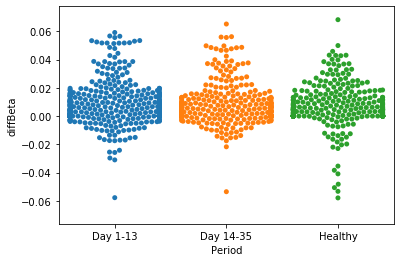

In [30]:
# df = pd.read_csv(figFolder+'lfpForR.csv')
sns.swarmplot(x='Period',y='diffBeta',data = df)
